# Rozpoznawanie gatunku ptaka po odgłosach
### *Bartosz Kąkol*
12.06.2025

---
#### Biblioteki

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

from tqdm import tqdm
import joblib

---
#### Konfiguracja

In [2]:
DATA_DIR = "/Volumes/Makaron/birdsong-recognition"
AUDIO_SIGNAL_WINDOW_DURATION = 10
AUDIO_SIGNAL_HOP_DURATION = 5
FEATURES_SAVE_DIR = "/Volumes/Makaron/birdsong-recognition/saved_features"
MODELS_SAVE_DIR = "/Volumes/Makaron/birdsong-recognition/saved_models"

---
## Cechy wyliczone przez `librosa`

Funkcje pomocnicze:

In [3]:
import librosa


def extract_features_from_audio_signal(y, sr):
    """
    Funkcja przekształcająca sygnał audio `y` z próbkowaniem `sr` na wektor 28 cech.
    """
    features = {
        "mfcc": np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1),
        "chroma": np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1),
        "spectral_centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        "spectral_rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        "zero_crossing_rate": np.mean(librosa.feature.zero_crossing_rate(y=y))
    }

    feature_vector = np.concatenate([
        features["mfcc"],
        features["chroma"],
        [features["spectral_centroid"]],
        [features["spectral_rolloff"]],
        [features["zero_crossing_rate"]]
    ])

    return feature_vector


def extract_features_sliding_window(file_path, window_duration, hop_duration):
    """
    Funkcja przekształcająca sygnał audio z pliku `file_path` na wektor cech przy użyciu przesuwającego się okna o długości `window_duration` i kroku `hop_duration`.
    """

    y, sr = librosa.load(file_path)

    window_samples = int(window_duration * sr)
    hop_samples = int(hop_duration * sr)

    features_list = []

    for start in range(0, len(y) - window_samples + 1, hop_samples):
        window = y[start:start + window_samples]
        features = extract_features_from_audio_signal(window, sr)
        features_list.append(features)

    return features_list


def prepare_dataset(csv_file_path: str) -> (np.array, np.array, dict, int):
    """
    Funkcja przygotowująca zbiór danych z pliku CSV `csv_file_path`, zwracająca macierz cech i etykiety.
    """

    features = []
    labels = []
    skipped = {
        "notfound": [],
        "empty": [],
        "error": []
    }
    file_count = 0

    df = pd.read_csv(csv_file_path)

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generowanie wektorów cech"):
        file_path = os.path.join(DATA_DIR, "train_audio", row["ebird_code"], row["filename"])
        species = row["species"]
        sound_duration = int(row["duration"])

        if not os.path.exists(file_path):
            skipped["notfound"].append(file_path)
            print(f"\nPominięto plik: {file_path} - Nie znaleziono!", file=sys.stderr)
            continue

        file_count += 1

        if sound_duration == 0:
            skipped["empty"].append(file_path)
            print(f"\nPominięto plik: {file_path} - Długość dźwięku wynosi 0!", file=sys.stderr)
            continue

        try:
            feature_vectors = extract_features_sliding_window(file_path, AUDIO_SIGNAL_WINDOW_DURATION, AUDIO_SIGNAL_HOP_DURATION)
        except Exception as e:
            print(f"\nBłąd podczas przetwarzania pliku: {file_path} - {e}", file=sys.stderr)
            skipped["error"].append(file_path)
            continue

        for feature_vector in feature_vectors:
            features.append(feature_vector)
            labels.append(species)

    return features, labels, skipped, file_count

Generowanie wektorów cech i etykiet na podstawie dźwięków opisanych w `train.csv`:

In [36]:
features, labels, skipped, file_count = prepare_dataset(os.path.join(DATA_DIR, "train.csv"))

print(f"Przygotowano {len(features)} wektorów cech z {file_count} plików audio.")
print(f"Pominięto {len(skipped['notfound'])} plików, których nie znaleziono.")
print(f"Pominięto {len(skipped['empty'])} plików z długością dźwięku równą 0.")
print(f"Pominięto {len(skipped['error'])} plików z błędami podczas przetwarzania.")

Generowanie wektorów cech:   0%|          | 4/21375 [00:00<56:53,  6.26it/s]


KeyboardInterrupt: 

In [4]:
FEATURES_FILE_NAME = "basic_264.npz"

Zapisanie wektorów cech i etykiet do pliku:

In [41]:
np.savez_compressed(os.path.join(FEATURES_SAVE_DIR, FEATURES_FILE_NAME), features=features, labels=labels)

Załadowanie wektorów cech i etykiet z pliku:

In [5]:
loaded_data = np.load(os.path.join(FEATURES_SAVE_DIR, FEATURES_FILE_NAME))
features = loaded_data["features"]
labels = loaded_data["labels"]
loaded_data = None

In [6]:
# Zmienne dla wygody
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63, stratify=y)

### Próba 1
`RandomForestClassifier`

In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=63)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=63)

Zapisanie modelu:

In [8]:
joblib.dump(clf, os.path.join(MODELS_SAVE_DIR, "randomforest_model.joblib"))

['/Volumes/Makaron/birdsong-recognition/saved_models/randomforest_model.joblib']

Załadowanie modelu:

In [ ]:
clf = joblib.load(os.path.join(MODELS_SAVE_DIR, "randomforest_model.joblib"))

Badanie krzywych uczenia

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Ten fragment kodu służący do tworzenia wykresów krzywych uczenia dla
# klasyfikatorów RandomForest o wartościach n_estimators równych 200, 300 i 400
# zużywa niebywałe ilości pamięci w niekontrolowany sposób i wyłączył mi komputer 2 razy!
# Ostrożnie.
for n_estimators_ in (200, 300, 400):
    print(f"n_estimators: {n_estimators_}")
    
    clf = RandomForestClassifier(n_estimators=n_estimators_, random_state=63)

    train_sizes, train_scores, validation_scores = learning_curve(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=2,
        train_sizes=[0.25, 0.50, 0.75, 1.0],
        scoring="accuracy",
        n_jobs=-1
    )

    plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Trening")
    plt.plot(train_sizes, np.mean(validation_scores, axis=1), label="Walidacja")
    plt.xlabel("Rozmiar zbioru treningowego")
    plt.ylabel("Dokładność")
    plt.legend()
    plt.show()

# Gotowa krzywa uczenia jest dostępna tylko dla n_estimators=100
# w folderze results/RandomForestClassifier/estimators_100 jako curve.png

N_estimators: 200


/Users/bartekk/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/bartekk/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/bartekk/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

In [48]:
y_pred = clf.predict(X_test)

# Raport
print(classification_report(y_test, y_pred, zero_division=0))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
cm_disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(100, 100)
plt.title("Macierz pomyłek")
plt.show()

                               precision    recall  f1-score   support

             Alder Flycatcher       0.89      0.90      0.89       225
              American Avocet       0.98      0.91      0.94        44
             American Bittern       0.88      0.94      0.91       105
             American Bushtit       0.90      0.98      0.94       150
       American Cliff Swallow       0.93      0.90      0.91       143
                American Coot       0.95      0.90      0.92        86
                American Crow       0.89      0.94      0.91       247
    American Dusky Flycatcher       0.91      0.92      0.92       178
           American Goldfinch       0.90      0.93      0.91       206
     American Grey Flycatcher       0.90      0.97      0.93       198
             American Kestrel       0.94      0.77      0.85        62
            American Redstart       0.92      0.93      0.92       234
               American Robin       0.90      0.95      0.92       244
     

"Sprawdzanie" przykładem:

In [55]:
test_i = 10000
test_pred = clf.predict(X_test[test_i].reshape(1, -1))

print("Prawdziwa etykieta:", y_test[test_i])
print("Przewidywana etykieta:", test_pred[0])
print("Poprawność:", test_pred[0] == y_test[test_i])

Prawdziwa etykieta: Costa's Hummingbird
Przewidywana etykieta: Costa's Hummingbird
Poprawność: True


---
### Próba 2
`Support Vector Classifier`

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

test_params = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1.0, 10.0],
    "gamma": ["scale", "auto", 0.001, 1.0]
}

grid_search = GridSearchCV(
    SVC(random_state=63),
    test_params,
    cv=3, n_jobs=-1, verbose=2,
    scoring="accuracy"
)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/bartekk/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/bartekk/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/bartekk/.pyenv/versions/3.12.0/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=33.8min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=33.9min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=33.9min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=37.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=37.9min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=38.0min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=38.0min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=38.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=38.0min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Use

[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=43.4min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=43.4min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=43.5min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=32.2min
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=32.2min
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=32.2min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=37.2min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=37.2min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ....................C=0.1, gamma=1.0, kernel=linear; total time=44.4min
[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time=39.1min
[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time=39.1min
[CV] END ....................C=0.1, gamma=1.0, kernel=linear; total time=44.7min
[CV] END ....................C=0.1, gamma=1.0, kernel=linear; total time=45.4min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=50.6min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .......................C=0.1, gamma=1.0, kernel=rbf; total time=53.2min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ..................C=1.0, gamma=scale, kernel=linear; total time=34.0min
[CV] END ..................C=1.0, gamma=scale, kernel=linear; total time=34.0min
[CV] END ..................C=1.0, gamma=scale, kernel=linear; total time=34.0min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=1.0, gamma=scale, kernel=rbf; total time=37.9min
[CV] END .....................C=1.0, gamma=scale, kernel=rbf; total time=39.6min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time=35.8min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time=37.9min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ......................C=1.0, gamma=auto, kernel=rbf; total time=34.2min
[CV] END ......................C=1.0, gamma=auto, kernel=rbf; total time=39.9min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=1.0, gamma=scale, kernel=rbf; total time=43.4min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time=45.7min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ......................C=1.0, gamma=auto, kernel=rbf; total time=36.7min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ..................C=1.0, gamma=0.001, kernel=linear; total time=39.8min
[CV] END ..................C=1.0, gamma=0.001, kernel=linear; total time=39.8min
[CV] END ..................C=1.0, gamma=0.001, kernel=linear; total time=40.2min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=1.0, gamma=0.001, kernel=rbf; total time=36.4min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=1.0, gamma=0.001, kernel=rbf; total time=36.1min
[CV] END ....................C=1.0, gamma=1.0, kernel=linear; total time=34.6min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=1.0, gamma=0.001, kernel=rbf; total time=45.6min
[CV] END ....................C=1.0, gamma=1.0, kernel=linear; total time=35.7min
[CV] END ....................C=1.0, gamma=1.0, kernel=linear; total time=42.4min
[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=40.4min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=40.3min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .......................C=1.0, gamma=1.0, kernel=rbf; total time=40.4min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ....................C=10.0, gamma=scale, kernel=rbf; total time=32.6min
[CV] END ....................C=10.0, gamma=scale, kernel=rbf; total time=32.4min
[CV] END ....................C=10.0, gamma=scale, kernel=rbf; total time=32.4min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=10.0, gamma=auto, kernel=rbf; total time=33.3min
[CV] END .....................C=10.0, gamma=auto, kernel=rbf; total time=30.8min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .....................C=10.0, gamma=auto, kernel=rbf; total time=31.0min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END .................C=10.0, gamma=scale, kernel=linear; total time=73.1min
[CV] END .................C=10.0, gamma=scale, kernel=linear; total time=73.4min
[CV] END .................C=10.0, gamma=scale, kernel=linear; total time=73.0min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


[CV] END ..................C=10.0, gamma=auto, kernel=linear; total time=69.9min
[CV] END ..................C=10.0, gamma=auto, kernel=linear; total time=70.6min
[CV] END ....................C=10.0, gamma=0.001, kernel=rbf; total time=31.9min
[CV] END ....................C=10.0, gamma=0.001, kernel=rbf; total time=32.0min
[CV] END ..................C=10.0, gamma=auto, kernel=linear; total time=69.6min
[CV] END ....................C=10.0, gamma=0.001, kernel=rbf; total time=32.0min


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Use

[CV] END .................C=10.0, gamma=0.001, kernel=linear; total time=65.1min
[CV] END .................C=10.0, gamma=0.001, kernel=linear; total time=64.0min
[CV] END .................C=10.0, gamma=0.001, kernel=linear; total time=63.9min
[CV] END ......................C=10.0, gamma=1.0, kernel=rbf; total time=34.9min
[CV] END ......................C=10.0, gamma=1.0, kernel=rbf; total time=34.9min
[CV] END ......................C=10.0, gamma=1.0, kernel=rbf; total time=34.6min
[CV] END ...................C=10.0, gamma=1.0, kernel=linear; total time=57.5min
[CV] END ...................C=10.0, gamma=1.0, kernel=linear; total time=57.4min
[CV] END ...................C=10.0, gamma=1.0, kernel=linear; total time=57.8min


GridSearchCV(cv=3, estimator=SVC(random_state=63), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 10.0],
                         'gamma': ['scale', 'auto', 0.001, 1.0],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [13]:
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model: SVC = grid_search.best_estimator_

Najlepsze parametry: {'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'}
Najlepszy wynik: 0.8075129982151705


Zapisanie modelu:

In [14]:
joblib.dump(best_model, os.path.join(MODELS_SAVE_DIR, "svm_model.joblib"))

['/Volumes/Makaron/birdsong-recognition/saved_models/svm_model.joblib']

Załadowanie modelu:

In [ ]:
best_model = joblib.load(os.path.join(MODELS_SAVE_DIR, "svm_model.joblib"))

In [ ]:
y_pred = best_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
cm_disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(100, 100)
plt.title("Macierz pomyłek dla SVM")
plt.show()

---
### Próba 3
`MLPClassifier`

In [7]:
from sklearn.preprocessing import LabelEncoder

X_scaled = StandardScaler().fit_transform(X)
y_encoded = LabelEncoder().fit_transform(y)

In [8]:
mlp_variants = {
    "small": (64, 32),
    "big": (256, 128, 64, 32),
    "wide": (200, 200),
    "deep": (100, 100, 100, 100, 50)
}


In [9]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=63)
results = {}

for name, hidden_layers in mlp_variants.items():
    print(f"\nTrening: {name}")
    model = MLPClassifier(
        # activation="relu",
        activation="tanh",
        shuffle=True,
        learning_rate="adaptive",
        hidden_layer_sizes=hidden_layers,
        max_iter=3000,
        early_stopping=True,
        random_state=63
    )
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results[name] = {
        "model": model,
        "score": score
    }
    print(f"{name} accuracy: {score}")

best_architecture = max(results.items(), key=lambda x: x[1]["score"])
print(f"\nNajlepszy: {best_architecture[0]} - {best_architecture[1]["score"]}")

best_model = results[best_architecture[0]]["model"]


Trening: small


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-pac

small accuracy: 0.30121057281344765

Trening: big


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-pac

big accuracy: 0.4882882452663499

Trening: wide


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-pac

wide accuracy: 0.6460686230032712

Trening: deep


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-pac

deep accuracy: 0.514887419116067

Najlepszy: wide - 0.6460686230032712


/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [10]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(100, 100)
plt.title(f"Macierz pomyłek")
plt.show()

/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


              precision    recall  f1-score   support

           0       0.64      0.67      0.65       227
           1       0.78      0.80      0.79        50
           2       0.67      0.82      0.74       102
           3       0.71      0.65      0.68       161
           4       0.70      0.66      0.68       146
           5       0.64      0.59      0.62        91
           6       0.79      0.70      0.74       257
           7       0.63      0.65      0.64       163
           8       0.55      0.49      0.52       181
           9       0.60      0.72      0.66       211
          10       0.63      0.43      0.51        63
          11       0.73      0.76      0.74       229
          12       0.69      0.69      0.69       229
          13       0.82      0.65      0.72       143
          14       0.62      0.69      0.65        26
          15       0.68      0.76      0.72       257
          16       0.73      0.68      0.70       165
          17       0.77    

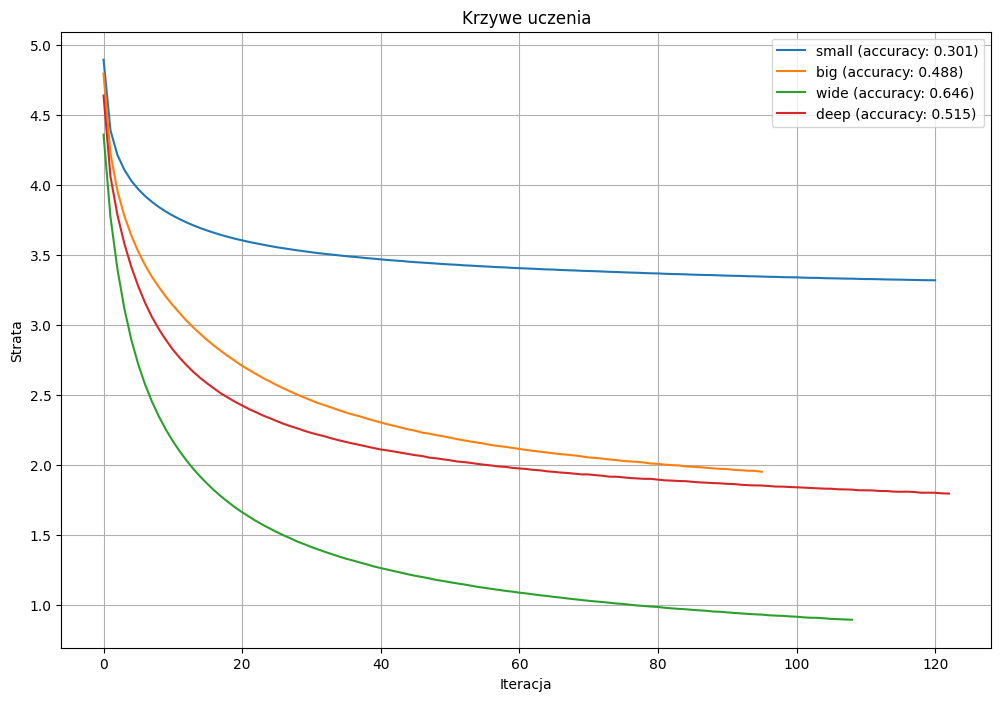

In [11]:
plt.figure(figsize=(12, 8))

for name, result in results.items():
    model = result["model"]
    plt.plot(model.loss_curve_, label=f"{name} (accuracy: {result["score"]:.3f})")

plt.xlabel("Iteracja")
plt.ylabel("Strata")
plt.title('Krzywe uczenia')
plt.legend()
plt.grid(True)
plt.show()


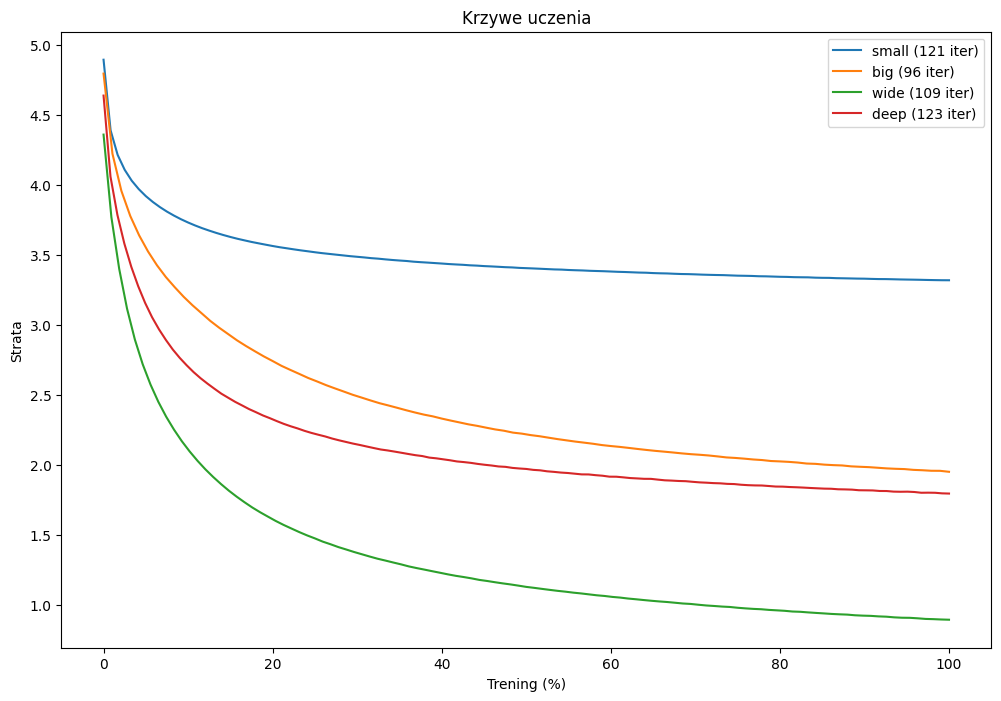

In [12]:
plt.figure(figsize=(12, 8))

for name, result in results.items():
    model = result["model"]
    iterations = len(model.loss_curve_)
    x_normalized = np.linspace(0, 100, iterations)
    plt.plot(x_normalized, model.loss_curve_, label=f"{name} ({iterations} iter)")

plt.xlabel("Trening (%)")
plt.ylabel("Strata")
plt.title("Krzywe uczenia")
plt.legend()


---
## Spektrogramy i sieć konwolucyjna

In [4]:
import librosa
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

Funkcje pomocnicze:

In [15]:
def create_spectrogram(y, sr):
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

    compressed = np.array(tf.image.resize(mel_spect_db[..., np.newaxis], [128, 128]))
    compressed = np.squeeze(compressed)

    return compressed


def create_spectrograms_sliding_window(file_path: str, window_duration, hop_duration):
    """
    Funkcja przekształcająca sygnał audio z pliku `file_path` na wektor spektrogramów przy użyciu przesuwającego się okna o długości `window_duration` i kroku `hop_duration`.
    """

    y, sr = librosa.load(file_path)

    window_samples = int(window_duration * sr)
    hop_samples = int(hop_duration * sr)

    spectrograms = []

    for start in range(0, len(y) - window_samples + 1, hop_samples):
        window = y[start:start + window_samples]
        spectrogram = create_spectrogram(window, sr)
        spectrograms.append(spectrogram)

    return spectrograms


def prepare_spectrogram_dataset(csv_file_path: str) -> (np.array, np.array, dict, int):
    """
    Funkcja przygotowująca zbiór danych z pliku CSV `csv_file_path`, zwracająca macierz cech i etykiety.
    """

    features = []
    labels = []
    skipped = {
        "notfound": [],
        "empty": [],
        "error": []
    }
    file_count = 0

    df = pd.read_csv(csv_file_path)

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generowanie spektrogramów"):
        file_path = os.path.join(DATA_DIR, "train_audio", row["ebird_code"], row["filename"])
        species = row["species"]
        sound_duration = int(row["duration"])

        if not os.path.exists(file_path):
            skipped["notfound"].append(file_path)
            print(f"\nPominięto plik: {file_path} - Nie znaleziono!", file=sys.stderr)
            continue

        file_count += 1

        if sound_duration == 0:
            skipped["empty"].append(file_path)
            print(f"\nPominięto plik: {file_path} - Długość dźwięku wynosi 0!", file=sys.stderr)
            continue

        try:
            feature_vectors = create_spectrograms_sliding_window(file_path, AUDIO_SIGNAL_WINDOW_DURATION, AUDIO_SIGNAL_HOP_DURATION)
        except Exception as e:
            print(f"\nBłąd podczas przetwarzania pliku: {file_path} - {e}", file=sys.stderr)
            skipped["error"].append(file_path)
            continue

        for feature_vector in feature_vectors:
            features.append(feature_vector)
            labels.append(species)

    return features, labels, skipped, file_count

In [50]:
features, labels, skipped, file_count = prepare_spectrogram_dataset(os.path.join(DATA_DIR, "train.csv"))

print(f"Przygotowano {len(features)} spektrogramów z {file_count} plików audio.")
print(f"Pominięto {len(skipped['notfound'])} plików, których nie znaleziono.")
print(f"Pominięto {len(skipped['empty'])} plików z długością dźwięku równą 0.")
print(f"Pominięto {len(skipped['error'])} plików z błędami podczas przetwarzania.")

Generowanie spektrogramów:   0%|          | 96/21375 [00:10<23:58, 14.80it/s]/var/folders/n8/652xqd7949ddz4vq0s24zfsm0000gn/T/ipykernel_11377/426492686.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Generowanie spektrogramów:   1%|          | 157/21375 [00:15<1:05:19,  5.41it/s]
Pominięto plik: /Volumes/Makaron/birdsong-recognition/train_audio/amebit/XC310046.mp3 - Długość dźwięku wynosi 0!
Note: Illegal Audio-MPEG-Header 0x656c2041 at offset 221435.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Generowanie spektrogramów:   1%|▏         | 270/21375 [00:26<31:12, 11.27it/s]Note: Illegal Audio-M

Przygotowano 209404 spektrogramów z 21375 plików audio.
Pominięto 0 plików, których nie znaleziono.
Pominięto 31 plików z długością dźwięku równą 0.
Pominięto 1 plików z błędami podczas przetwarzania.


In [5]:
FEATURES_FILE_NAME = "spectrograms_264.npz"

Zapisanie spektrogramów:

In [52]:
np.savez_compressed(os.path.join(FEATURES_SAVE_DIR, FEATURES_FILE_NAME), features=features, labels=labels)

Załadowanie spektrogramów:

In [6]:
loaded_data = np.load(os.path.join(FEATURES_SAVE_DIR, FEATURES_FILE_NAME))
features = loaded_data["features"]
labels = loaded_data["labels"]
loaded_data = None

In [7]:
# Zmienne dla wygody
X = features
y = labels
y_cat = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=63, stratify=y)

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(len(np.unique(y)), activation="softmax")
])

# y_train_cat = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(y_train))
# y_test_cat = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(y_test))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(MODELS_SAVE_DIR, "model_epoch_{epoch:02d}.keras"),
    save_weights_only=False,
    save_freq="epoch",
    verbose=1
)

history = model.fit(X_train, y_train,
                    epochs=60,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_callback],
                    verbose=1)

/Users/bartekk/PycharmProjects/bird-sound-recognition/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-16 22:58:58.273657: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-16 22:58:58.317908: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-16 22:58:58.318152: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1750107538.319208 3888408 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750107538.320594 3888408 pluggable_device_factory.cc:271] Created TensorFlow device (/job:loca

Epoch 1/60


2025-06-16 23:00:14.498983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.0119 - loss: 5.5250
Epoch 1: saving model to /Volumes/Makaron/birdsong-recognition/saved_models/model_epoch_01.keras
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 418s 317ms/step - accuracy: 0.0119 - loss: 5.5250 - val_accuracy: 0.0014 - val_loss: 292394.4062
Epoch 2/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.0124 - loss: 5.4256
Epoch 2: saving model to /Volumes/Makaron/birdsong-recognition/saved_models/model_epoch_02.keras
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 413s 315ms/step - accuracy: 0.0124 - loss: 5.4256 - val_accuracy: 0.0014 - val_loss: 293242.7188
Epoch 3/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.0124 - loss: 5.4094
Epoch 3: saving model to /Volumes/Makaron/birdsong-recognition/saved_models/model_epoch_03.keras
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 417s 319ms/step - accuracy: 0.0124 - loss: 5.4094 - val_accuracy: 0.0014 - val_loss: 293242.6250
Epoch 4/60
1309/1309 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy

KeyboardInterrupt: 

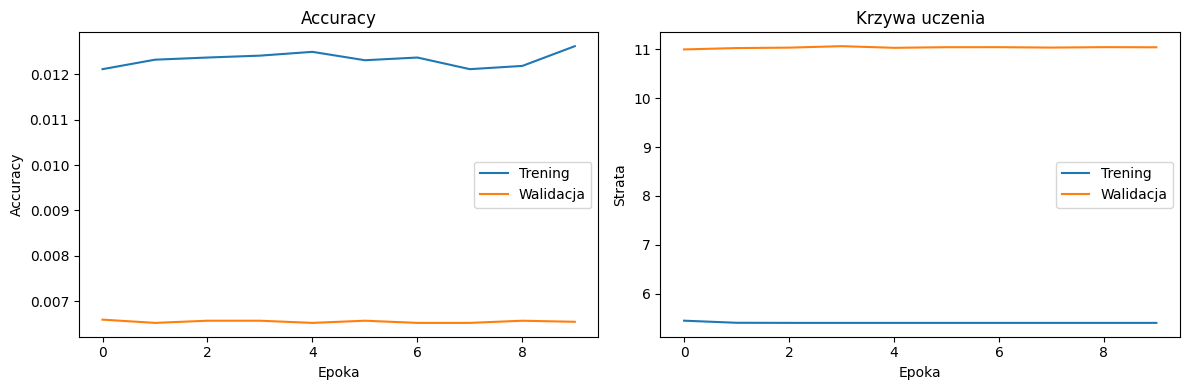

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 264)            │        17,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,852,698 (37.59 MB)

 Trainable params: 3,284,232 (12.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,568,466 (25.06 MB)

accuracy: 0.006542345974594355
loss: 11.04330825805664


In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Trening")
plt.plot(history.history["val_accuracy"], label="Walidacja")
plt.title("Accuracy")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Trening")
plt.plot(history.history["val_loss"], label="Walidacja")
plt.title("Krzywa uczenia")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.tight_layout()
plt.show()

model.summary()

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"accuracy: {test_accuracy}")
print(f"loss: {test_loss}")